#Flower Classification using Deep Learning(CNN)
-------------------------
Dataset:

Source: Flowers Recognition Dataset from Kaggle

Structure: 5 folders (one for each flower class)
['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

Images per class: 1000

Total images: 4999

lilly-999

lotus-1000

orchid-1000

sunflower-1000

tulip-1000

in this project i built a deep learning based flower classification to identify five different types of flowers using image data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing all the libraries
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np

#EDA
----------------------------

In [ ]:
data_path = "/content/drive/MyDrive/flowers/flower_images"
import cv2

img = cv2.imread("/content/drive/MyDrive/flowers/flower_images/Lilly/001ff6644e.jpg")
print(f"Shape: {img.shape}")  # (height, width, channels)

# Data Augmentation- apply random transformations to simulate new images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Shape: (996, 1500, 3)
Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


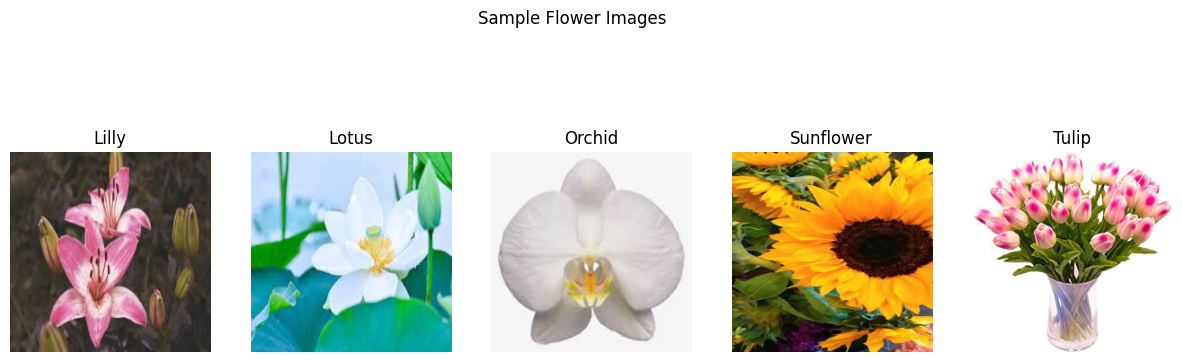

In [ ]:
# Visualize sample images
plt.figure(figsize=(15, 5))
IMG_SIZE = 224 # Define IMG_SIZE before using it
base_path = "/content/drive/MyDrive/flowers/flower_images" # Define base_path
categories = os.listdir(base_path) # Define categories from directory names
for i, category in enumerate(categories):
    img_path = os.path.join(base_path, category, os.listdir(os.path.join(base_path, category))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.suptitle('Sample Flower Images')
plt.show()

In [ ]:
import os
def count_images_per_class(folder_path):
    total_images = 0
    class_counts = {}

    for class_name in sorted(os.listdir(folder_path)):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len([
                file for file in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = count
            total_images += count
            print(f"{class_name}: {count} image(s)")

    print(f"\n Total classes: {len(class_counts)}")
    print(f" Total images: {total_images}")

# Call the function
data_path = "/content/drive/MyDrive/flowers/flower_images"
count_images_per_class(data_path)

Lilly: 999 image(s)
Lotus: 1000 image(s)
Orchid: 1000 image(s)
Sunflower: 1000 image(s)
Tulip: 1000 image(s)

 Total classes: 5
 Total images: 4999


 Image Count per Class:
Lilly: 1000 image(s)
Lotus: 1000 image(s)
Orchid: 1000 image(s)
Sunflower: 1000 image(s)
Tulip: 1000 image(s)


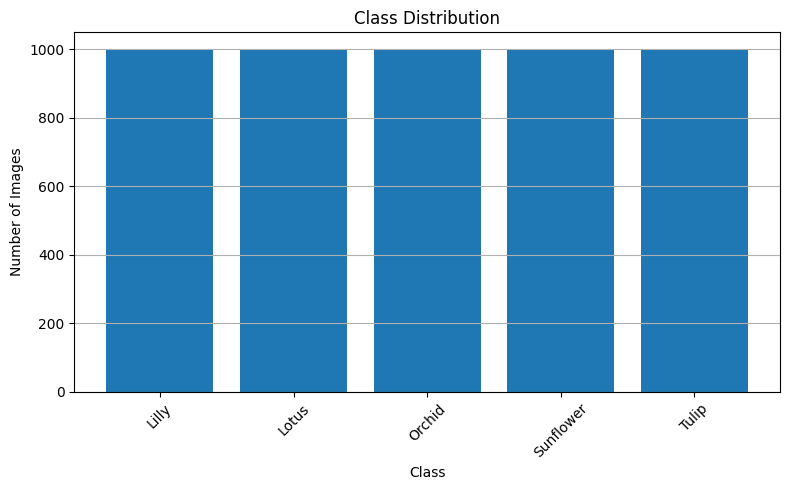

 Dataset is BALANCED.


In [ ]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt

def analyze_class_distribution(data_path):
    class_counts = {}
    for class_name in sorted(os.listdir(data_path)):
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            count = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = count

    # Print counts
    print(" Image Count per Class:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} image(s)")

    # Plot the distribution
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Check for imbalance
    counts = list(class_counts.values())
    mean = np.mean(counts)
    imbalance = any(c > 1.5 * mean or c < 0.5 * mean for c in counts)

    if imbalance:
        print(" Dataset is IMBALANCED.")
    else:
        print(" Dataset is BALANCED.")

# Use your data path here
analyze_class_distribution("/content/drive/MyDrive/flowers/flower_images")

#Data preprocessing
---------------------------

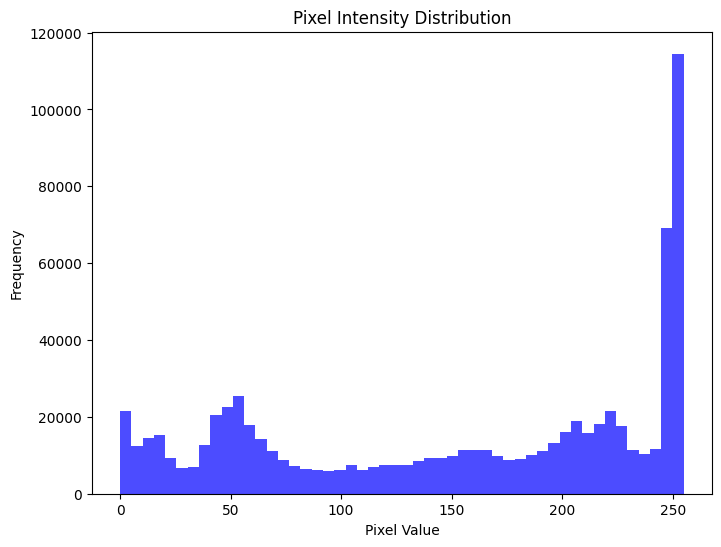

In [ ]:
# Pixel intensity distribution- to understand the brightness and contrast patterns in each image class(to choose normalization or augmentation)
def plot_pixel_distribution():
    pixel_values = []
    for category in categories:
        img_path = os.path.join(base_path, category, os.listdir(os.path.join(base_path, category))[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        pixel_values.append(img.flatten())
    pixel_values = np.concatenate(pixel_values)
    plt.figure(figsize=(8, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()
plot_pixel_distribution()

high spike at pixel value 255. this means large number of pixels are very bright or white

this insight helped me understand contrast and brightness variation in images

In [ ]:
import os
from PIL import Image

def clean_dataset(path):
    removed = 0
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                img = Image.open(fpath)
                img.verify()
            except Exception as e:
                print(f"Removing corrupted file: {fpath}")
                os.remove(fpath)
                removed += 1
    print(f"Cleanup complete. Removed {removed} bad image(s).")

clean_dataset("/content/drive/MyDrive/flowers/flower_images")


Cleanup complete. Removed 0 bad image(s).


In [ ]:
import os
print("Inside /content/flowers:")
print(os.listdir("/content/drive/MyDrive/flowers/flower_images"))

Inside /content/flowers:
['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


#Model building
--------------------------

In [ ]:
num_classes = len(train_data.class_indices)
num_classes

5

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
# custom cnn - feature extraction(conv2d), pooling layers(Down sampling), dense layers(for final clasification)
# Block 1
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(224,224, 3))) # detects features like edges, shapes, patterns in images
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2))) # reduce size of feature map by keeping only most important or maximum value in window - reduce overfitting, speed up training
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,410,705 (1.15 GB)

 Trainable params: 103,136,261 (393.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 206,272,524 (786.87 MB)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model1.keras",
                             monitor="val_loss",
                             save_best_only=True,
                             verbose=1)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4058 - loss: 1.8992 
Epoch 1: val_loss improved from inf to 1.92127, saving model to best_model1.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2068s 16s/step - accuracy: 0.4061 - loss: 1.8969 - val_accuracy: 0.2420 - val_loss: 1.9213
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5468 - loss: 1.2556 
Epoch 2: val_loss improved from 1.92127 to 1.60181, saving model to best_model1.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2053s 16s/step - accuracy: 0.5469 - loss: 1.2553 - val_accuracy: 0.4010 - val_loss: 1.6018
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5873 - loss: 1.1037 
Epoch 3: val_loss improved from 1.60181 to 1.44671, saving model to best_model1.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2088s 17s/step - accuracy: 0.5873 - loss: 1.1036 - val_accuracy: 0.4590 - val_loss: 1.4467
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6132 - loss: 1.0335 
Epoch 4: val_loss improved from 1.4467

In [ ]:
test_accuracy=model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy[1]*100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 0.6997 - loss: 0.8680
Test Accuracy: 70.93%


#Model Training
-------------------------

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import regularizers
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.applications import ResNet50
from keras.optimizers import Adam, Adamax
from keras.callbacks import EarlyStopping
# each layer is connected to every other layer in a feed-forward fashion - strong feature reuse, has 121 layers important for vanishing gradient problem

# transfer learning- technique where model developed for one task is reused for a different but related task

base_model = DenseNet121(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3)) # conv 120, 1 fully connected layer

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01),)) # l2 adds penality to loss function based on weights, keep weights small but non-zero

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5, activation='softmax'))
# adamax optimizer because it is more stable for models with sparse gradients(many values are zero) and can handle exploding gradients more effectively
# Compile
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,306,309 (27.87 MB)

 Trainable params: 266,245 (1.02 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.5492 - loss: 4.9228 - val_accuracy: 0.8210 - val_loss: 3.3350
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 688ms/step - accuracy: 0.7988 - loss: 3.2815 - val_accuracy: 0.8500 - val_loss: 2.8027
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 673ms/step - accuracy: 0.8502 - loss: 2.7554 - val_accuracy: 0.8620 - val_loss: 2.4898
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 706ms/step - accuracy: 0.8608 - loss: 2.4388 - val_accuracy: 0.8750 - val_loss: 2.2331
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 685ms/step - accuracy: 0.8743 - loss: 2.1830 - val_accuracy: 0.8920 - val_loss: 2.0080
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 696ms/step - accuracy: 0.8909 - loss: 1.9628 - val_accuracy: 0.9000 - val_loss: 1.8138
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 684ms/step - accuracy: 0.8841 - loss: 1.7829 - val_accuracy: 0.9080 - val_loss: 1.6603
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 675ms/step - accuracy: 0.9134 - loss: 1.6

#Evaluation and testing
---------------------------

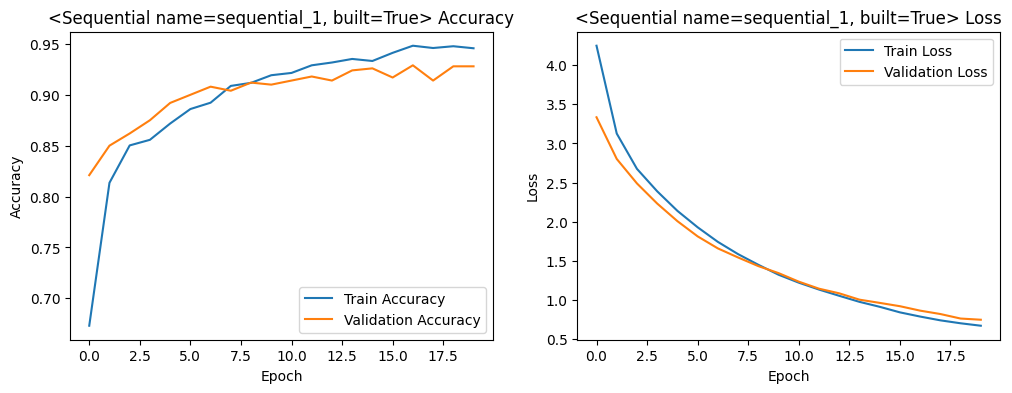

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model} Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
dense_eval = model.evaluate(val_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 792ms/step - accuracy: 0.9065 - loss: 0.7912


In [ ]:
train_acc=model.evaluate(train_data)
print(f"Train Accuracy: {train_acc[1]*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 534ms/step - accuracy: 0.9859 - loss: 0.5616
Train Accuracy: 98.70%


In [ ]:
test_accuracy=model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy[1]*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 545ms/step - accuracy: 0.9164 - loss: 0.7909
Test Accuracy: 93.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


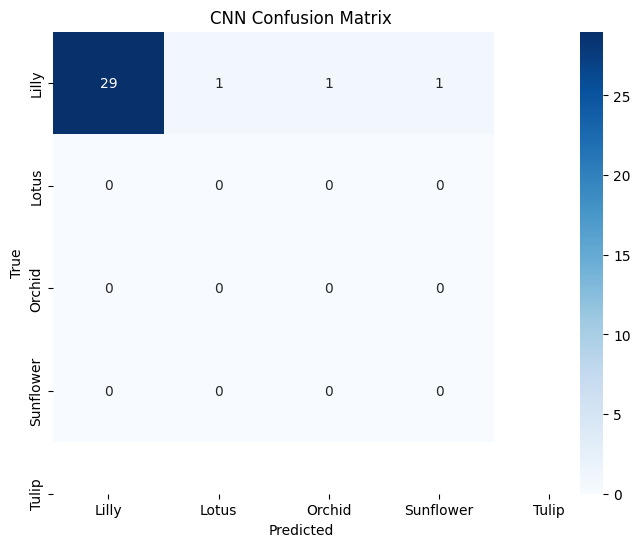

In [ ]:
# Confusion matrix for CNN
val_images, val_labels = next(val_data)
cnn_predictions = model.predict(val_images)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
cnn_true_classes = np.argmax(val_labels, axis=1)
cm = confusion_matrix(cnn_true_classes, cnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


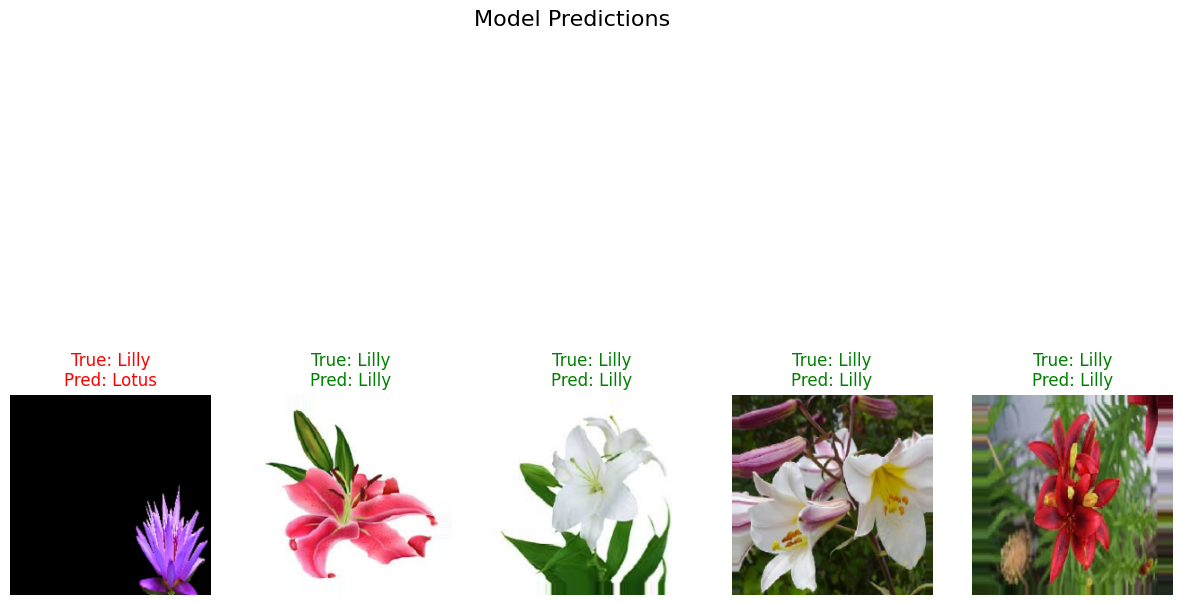

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def predict_and_visualize(model, generator, class_names, num_images=5):
    # Get a batch of images and labels from the generator
    images, true_labels = next(generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label_name = class_names[true_classes[i]]
        predicted_label_name = class_names[predicted_classes[i]]

        title_color = "green" if true_classes[i] == predicted_classes[i] else "red"
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=title_color)
        plt.axis('off')
    plt.suptitle("Model Predictions", fontsize=16)
    plt.show()

# Get class names from the generator
class_names = list(val_data.class_indices.keys())

predict_and_visualize(model, val_data, class_names)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input # Import preprocess_input for DenseNet


# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use DenseNet's preprocess_input
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_data.class_indices)


base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224, 3)) # use the pre-trained DenseNet121 as a base, and add own classification layers to adapt to dataset’s unique classes
for layer in base_model.layers:
    layer.trainable = False # freezing base layers to retain pre-learned features

x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces the spatial dimensions, outputting a single vector per image.
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

densenet_model = Model(inputs=base_model.input, outputs=output)
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop4 = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
checkpoint2 = ModelCheckpoint("best_model4.keras",
                             monitor="val_loss",
                             save_best_only=True,
                             verbose=1)

history2=densenet_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stop4,checkpoint2]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.5579 - loss: 1.1321
Epoch 1: val_loss improved from inf to 0.43555, saving model to best_model4.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 943ms/step - accuracy: 0.5590 - loss: 1.1292 - val_accuracy: 0.8350 - val_loss: 0.4356
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8438 - loss: 0.4276
Epoch 2: val_loss improved from 0.43555 to 0.37469, saving model to best_model4.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 754ms/step - accuracy: 0.8438 - loss: 0.4276 - val_accuracy: 0.8650 - val_loss: 0.3747
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8733 - loss: 0.3643
Epoch 3: val_loss improved from 0.37469 to 0.31278, saving model to best_model4.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 759ms/step - accuracy: 0.8733 - loss: 0.3643 - val_accuracy: 0.8910 - val_loss: 0.3128
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8887 - loss: 0.3123
Epoch 4: val_loss improved from 0

In [ ]:
densenet_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,433,041 (28.35 MB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 263,692 (1.01 MB)

In [ ]:
dense_eval = densenet_model.evaluate(val_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 554ms/step - accuracy: 0.9212 - loss: 0.2315


In [ ]:
train_accuracy3=densenet_model.evaluate(train_data)
print(f"Train Accuracy: {train_accuracy3[1]*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 544ms/step - accuracy: 0.9819 - loss: 0.0640
Train Accuracy: 98.10%


In [ ]:
test_accuracy3=densenet_model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy3[1]*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.9299 - loss: 0.2220
Test Accuracy: 93.30%


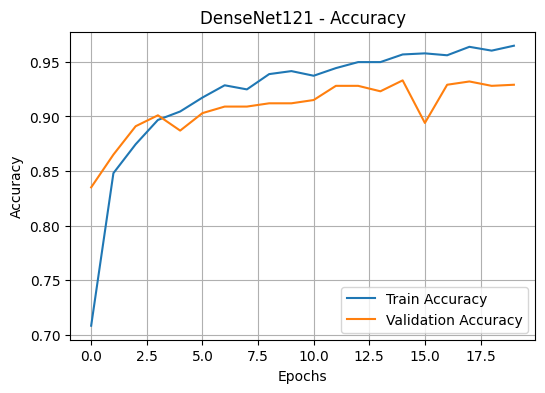

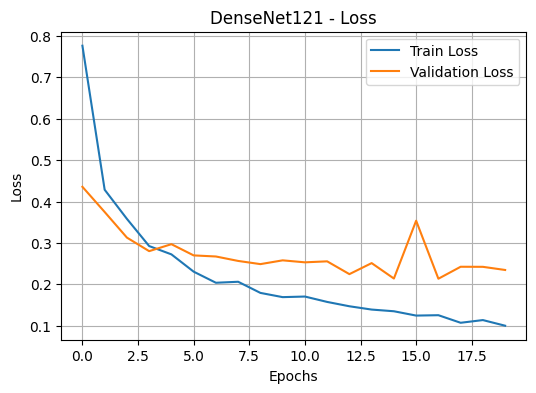

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet121 - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('DenseNet121 - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_data.reset() # Ensure the generator is reset for consistent evaluation
# Get all batches from the generator
all_val_images = []
all_val_labels = []

# This loop iterates through the entire validation set, collects all the (images, labels) in lists, and concatenates them into arrays.
# obtain two large arrays: one with all validation images and one with corresponding labels

for i in range(len(val_data)):
    images, labels = next(val_data)
    all_val_images.append(images)
    all_val_labels.append(labels)

all_val_images = np.concatenate(all_val_images)
all_val_labels = np.concatenate(all_val_labels)
preds = densenet_model.predict(all_val_images) # Use densenet_model for prediction on all validation images
y_pred = np.argmax(preds, axis=1)
# Converts probabilities to actual class indices (the highest probability indicates the chosen class for each image)

# Get true labels
y_true = np.argmax(all_val_labels, axis=1)
# The true labels are typically one-hot encoded (e.g., [0, for class 1 out of 5), so np.argmax reverses this back to an integer class index for each sample.

# Get labels in the correct order
labels = list(val_data.class_indices.keys()) # Use val_data for class labels


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
Classification Report:
              precision    recall  f1-score   support

       Lilly       0.88      0.93      0.90       200
       Lotus       0.93      0.92      0.92       200
      Orchid       0.93      0.94      0.94       200
   Sunflower       1.00      0.98      0.99       200
       Tulip       0.94      0.92      0.93       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Precision is the proportion of correctly predicted images for that flower out of all images the model labeled as that flower,

Recall is the proportion of that flower correctly found out of all true images of that flower in the data,

F1-score combines precision and recall to give a balanced score,

Support is the total number of true images for that flower (e.g., 200 each in results).

Example:

For Sunflower — Precision (1.00) means every image predicted as Sunflower was correct, Recall (0.98) means 98% of all actual Sunflowers were identified, F1-score (0.99) is the balance, and Support (200) shows there were 200 Sunflower images in the validation set.



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


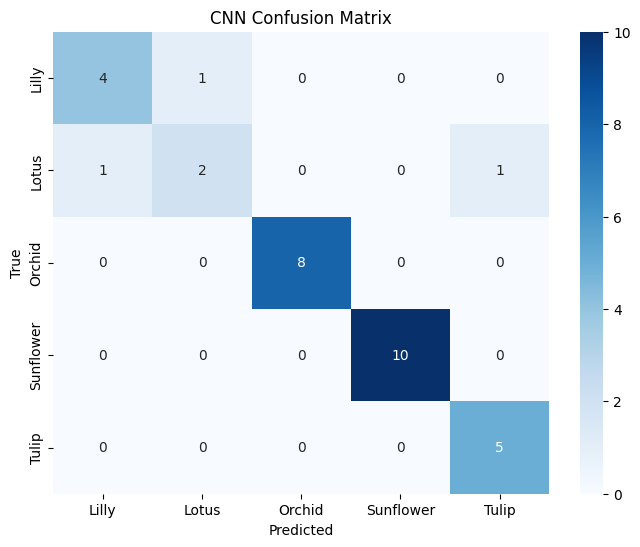

In [ ]:
# Confusion matrix for CNN
val_images, val_labels = next(val_data)
cnn_predictions = densenet_model.predict(val_images)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
cnn_true_classes = np.argmax(val_labels, axis=1)
cm = confusion_matrix(cnn_true_classes, cnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


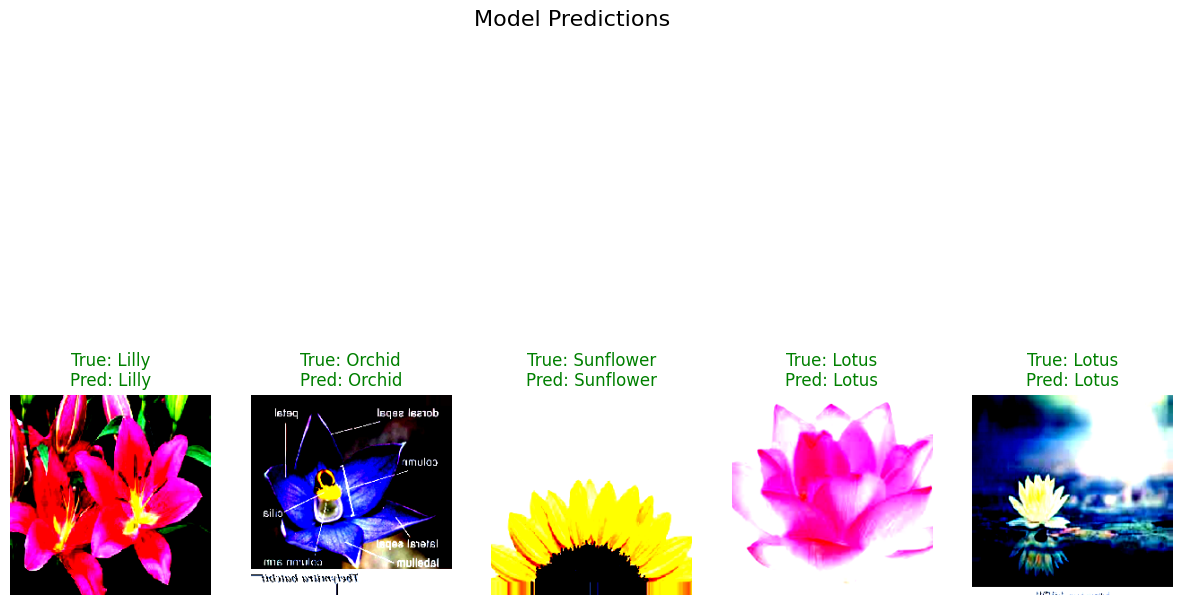

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def predict_and_visualize(model, generator, class_names, num_images=5):
    # Get a batch of images and labels from the generator
    images, true_labels = next(generator)

    # Make predictions
    predictions = densenet_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label_name = class_names[true_classes[i]]
        predicted_label_name = class_names[predicted_classes[i]]

        title_color = "green" if true_classes[i] == predicted_classes[i] else "red"
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=title_color)
        plt.axis('off')
    plt.suptitle("Model Predictions", fontsize=16)
    plt.show()

# Get class names from the generator
class_names = list(val_data.class_indices.keys())

predict_and_visualize(model, val_data, class_names)

#**Final Report: Flower Classification Using CNN**
-----------------------------------------------------

**Objective:**
To build a Convolutional Neural Network (CNN) that classifies images of flowers into 5 categories:
['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

Dataset:
Source: Flowers Recognition Dataset from Kaggle

Structure: 5 folders (one for each flower class)

Images per class: 1000

Total images: 4999

Data split: 80% training, 20% validation

Steps Performed:

**EDA (Exploratory Data Analysis):**
---------------------------------------------------------------
Visualized the number of images per flower class

Verified balanced dataset


**Data Preprocessing:**
---------------------------------------------------------------
Resized all images to 100x100 pixels

Normalized pixel values (rescale to [0, 1])

Applied data augmentation: rotation, zoom, and horizontal flip

Used ImageDataGenerator for loading and augmenting images

**CNN Model Architecture:**
---------------------------------------------------------------
3 Convolutional layers (32, 64, 128 filters)

MaxPooling after each Conv layer

Flatten layer → Dense(128) → Dropout(0.5)

Final layer: Dense(5) with softmax activation

Loss: categorical crossentropy

then used **DenseNet121** model

with GlobalAveragePooling2D

and dense layer

**Training and Evaluation:**
---------------------------------------------------------------
Trained custom cnn model for 10 epochs

then trained with DenseNet121 model with 20 epochs and

Observed training and validation accuracy/loss

Plotted accuracy curves

Achieved 93% validation accuracy


**Hyperparameter Tuning:**
---------------------------------------------------------------
Tuned dropout, and data augmentation

Tried more epochs (15–20) for accuracy boost

Avoided overfitting using dropout and augmentation

**Results & Achievements:**
---------------------------------------------------------------

Model Type	    DenseNet121

No. of Classes	5

Image Size	    224x224 RGB

Final Accuracy	training- 98.7% testing- 93.30% validation- 94%

Overfitting	    Prevented


